## Final Project Investigation of Adminstrative Link Between City of Chicago Business License Statuses vs Food Inspection Outcomes


#### Install packages and import libraries for data ingestion, cleaning, and visualization

In [74]:
pip install pandoc

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34821 sha256=5cca8425344b0dc8cdf5fefc9ae3a5389c5d1fa5bef20e40f5763160b8fe8c5d
  Stored in directory: c:\users\gsban\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built pandoc
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sqlalchemy pymysql

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import dask.dataframe as dd  # For large dataframes
import nbconvert
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import calendar
import geopandas as gpd
from dash import Dash, dcc, html, Input, Output


### Data Ingestion & Cleaning - Only Using Last 5 Years

In [14]:
# use Dask for large datasets like Business Licenses
licenses_path = "Business_Licenses.csv"  # https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/about_data
inspections_path = "Food_Inspections.csv" # https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5/about_data

# ingesting licenses dataset for locations table
licenses_for_locations = dd.read_csv(
    "Business_Licenses.csv",
    dtype={
        'ACCOUNT NUMBER': 'object',
        'DOING BUSINESS AS NAME': 'object',
        'LEGAL NAME': 'object',
        'ADDRESS': 'object',
        'CITY': 'object',
        'STATE': 'object',
        'ZIP CODE': 'object',
        'WARD': 'float64',
        'COMMUNITY AREA': 'float64',
        'LOCATION': 'object',
        'LICENSE ID': 'object',
        'LICENSE NUMBER': 'object',
        'BUSINESS ACTIVITY': 'object',
        'LICENSE STATUS': 'object',
        'LICENSE TERM START DATE': 'object',
        'LICENSE TERM EXPIRATION DATE': 'object'
    },
    assume_missing=True) 

# date time conversion
licenses_for_locations["LICENSE TERM EXPIRATION DATE"] = dd.to_datetime(licenses_for_locations["LICENSE TERM EXPIRATION DATE"], errors="coerce")

# ingesting inspections dataset for locations table
inspections_for_locations = pd.read_csv(inspections_path, parse_dates=['Inspection Date'])
# data filter to ensure only inspections from 2020 or later are present in the dataset
inspections_for_locations = inspections_for_locations[inspections_for_locations["Inspection Date"] > "01/01/2020"]

# ingest for other tables
licenses = dd.read_csv("Business_Licenses.csv", dtype=str,  assume_missing=True, parse_dates=["LICENSE TERM EXPIRATION DATE"])  # read everything as string to avoid dtype issues
licenses["LICENSE TERM EXPIRATION DATE"] = dd.to_datetime(
    licenses["LICENSE TERM EXPIRATION DATE"], 
    format="%m/%d/%Y",
    errors="coerce"
)
# data filter to ensure only active licenses from 2020 or later are present in the dataset
licenses = licenses[licenses["LICENSE TERM EXPIRATION DATE"] > "01/01/2020"]

inspections = pd.read_csv("Food_Inspections.csv", parse_dates=['Inspection Date'])
# data filter to ensure only inspections from 2020 or later are present in the dataset
inspections = inspections[inspections["Inspection Date"] > "01/01/2020"]

### Table Creation & Normalization

#### Location Table Normalized to: Location ID (PK), Address, City, State, Zip Code

In [12]:
# Extract location data from Dask DataFrames and convert to pandas
loc_licenses = licenses_for_locations[['ADDRESS', 'CITY', 'STATE', 'ZIP CODE']].compute().rename(columns={
    'ADDRESS': 'address',
    'CITY': 'city',
    'STATE': 'state',
    'ZIP CODE': 'zip_code'
})
loc_licenses['zip_code'] = (
    loc_licenses['zip_code']
    .astype(str)
    .str.strip()
    .str.upper()
    .str.zfill(5)
)
column_map = {
    col: new for col, new in {
        'Address': 'address',
        'City': 'city',
        'State': 'state',
        'ZIP': 'zip_code',
        'Zip': 'zip_code'
    }.items() if col in inspections.columns
}

inspections_for_locations = inspections_for_locations.rename(columns=column_map)

if 'zip_code' not in inspections_for_locations.columns:
    raise ValueError("ZIP column not found in inspections data.")

inspections_for_locations['zip_code'] = (
    inspections_for_locations['zip_code']
    .astype(str)
    .str.strip()
    .str.upper()
    .str.zfill(5)
)

loc_inspections = inspections_for_locations[['address', 'city', 'state', 'zip_code']].copy()

# normalize LOCATIONS table
for df in [loc_licenses, loc_inspections]:
    for col in ['address', 'city', 'state']:
        df[col] = df[col].astype(str).str.strip().str.upper()

# combine locations from both datasets but ensure duplicates are dropped
locations_df = pd.concat([loc_licenses, loc_inspections]).drop_duplicates().reset_index(drop=True)

# adding new surrogate column location_id to act as Primary Key of normalized table
locations_df['location_id'] = locations_df.index + 1

print(locations_df.head())

                address         city state zip_code  location_id
0        O'HARE AIRPORT      CHICAGO    IL    60666            1
1  1000  WASHINGTON AVE     ST LOUIS    MO    63101            2
2          1017  CIRCLE  FOREST PARK    IL    60130            3
3        1017 S WENONAH     OAK PARK    IL    60304            4
4   1073  ELMHURST  1ST  PARK FOREST    IL    60466            5


#### Businesses Table Normalized to: Business ID (PK), Account Number, Doing Business As Name, and Legal Name

In [18]:
businesses_df = licenses[[
    'ACCOUNT NUMBER',
    'DOING BUSINESS AS NAME',
    'LEGAL NAME'
]].drop_duplicates().rename(columns={
    'ACCOUNT NUMBER': 'account_number',
    'DOING BUSINESS AS NAME': 'dba_name',
    'LEGAL NAME': 'legal_name'
})

# convert to pandas to safely use reset_index and indexing
businesses_df = businesses_df.compute()
businesses_df = businesses_df.dropna(subset=['account_number'])
# keep only the first row for each account_number
businesses_df = businesses_df.drop_duplicates(subset="account_number").reset_index(drop=True)
# create surrogate key
businesses_df["business_id"] = businesses_df.index + 1

print(businesses_df.head())

  account_number                         dba_name  \
0         374129             SUMP PUMP MEDIC INC.   
1         350754             SCOTTISH PLUMBER LLC   
2          28155         ROBINETTE DEMOLITION INC   
3         221748  ARTISAN HEATING AND COOLING INC   
4          19616       MARK I RESTORATION COMPANY   

                         legal_name  business_id  
0              SUMP PUMP MEDIC INC.            1  
1              SCOTTISH PLUMBER LLC            2  
2          ROBINETTE DEMOLITION INC            3  
3  ARTISAN HEATING AND COOLING INC.            4  
4        MARK I RESTORATION COMPANY            5  


#### Licenses Table Normalized to: License ID, Account Number, License Number, License Code, License Description, License Status, Application Type, License Term Start Date, Licesnes Term Expiration Date

Note - Not fully normalized

In [21]:
# cleaning license data

licenses_df = licenses[[
    'LICENSE ID', 'ACCOUNT NUMBER', 'LICENSE NUMBER',
    'LICENSE CODE', 'LICENSE DESCRIPTION', 'LICENSE STATUS',
    'APPLICATION TYPE', 'LICENSE TERM START DATE', 'LICENSE TERM EXPIRATION DATE',
    'ADDRESS', 'CITY', 'STATE', 'ZIP CODE'
]].drop_duplicates().rename(columns={
    'LICENSE ID': 'license_id',
    'ACCOUNT NUMBER': 'account_number',
    'ADDRESS': 'address',
    'CITY': 'city',
    'STATE': 'state',
    'ZIP CODE': 'zip_code',
    'LICENSE NUMBER': 'license_number',
    'LICENSE CODE': 'license_code',
    'LICENSE DESCRIPTION': 'description',
    'LICENSE STATUS': 'license_status',
    'APPLICATION TYPE': 'application_type',
    'LICENSE TERM START DATE': 'start_date',
    'LICENSE TERM EXPIRATION DATE': 'end_date'
})

licenses_df['start_date'] = dd.to_datetime(licenses_df['start_date'], errors='coerce')
licenses_df['end_date'] = dd.to_datetime(licenses_df['end_date'], errors='coerce')
# licenses_df['location_id'] = None  # placeholder

licenses_df = licenses_df.dropna(subset=['license_id', 'account_number'])

# pandas dataframes
licenses_df = licenses_df.compute()
businesses_df = businesses_df.copy() 
# same type for account_number
licenses_df['account_number'] = licenses_df['account_number'].astype(str).str.strip()
businesses_df['account_number'] = businesses_df['account_number'].astype(str).str.strip()

licenses_df = licenses_df.merge(
    businesses_df[["account_number", "business_id"]],
    on="account_number",
    how="left"
)
# licenses_df = licenses_df.compute()

print(licenses_df.head())

  license_id account_number license_number license_code  \
0    2828914         280973        1798308         1010   
1    2837211         209806        1915331         1010   
2    2949144          52120          19755         1010   
3    2576354         202440        1579814         1010   
4    2730740         354182        2041589         1010   

                description license_status application_type start_date  \
0  Limited Business License            AAI            RENEW 2022-03-16   
1  Limited Business License            AAI            RENEW 2022-05-16   
2  Limited Business License            AAI            RENEW 2024-03-16   
3  Limited Business License            AAI            RENEW 2018-03-16   
4  Limited Business License            AAI            RENEW 2020-07-16   

    end_date                   address         city state zip_code  \
0 2024-03-15           4633 W 138TH ST    CRESTWOOD    IL    60445   
1 2024-05-15      7421 W ARCHER AVE 1A       SUMMIT    IL   

#### Inspections Table Normalized to:

Note - Not fully normalized

In [24]:
inspections_df = inspections[[
    'Inspection ID', 'License #', 'Inspection Date',
    'Inspection Type', 'Results', 'Risk', 'Facility Type',
    'Address', 'City', 'State', 'Zip'
]].dropna(subset=['License #', 'Inspection ID'])

inspections_df['Inspection Date'] = pd.to_datetime(inspections_df['Inspection Date'], errors='coerce')

inspections_df.rename(columns={
    'Inspection ID': 'inspection_id',
    'License #': 'license_id',
    'Inspection Date': 'inspection_date',
    'Inspection Type': 'inspection_type',
    'Results': 'result',
    'Risk': 'risk_level',
    'Facility Type': 'facility_type',
    'Address': 'address',
    'City': 'city',
    'State': 'state',
    'Zip': 'zip_code',#
}, inplace=True)

inspections_df['license_id'] = (
    inspections_df['license_id']
    .astype(str)
    .str.strip()
    .str.replace('.0', '', regex=False)  # remove trailing decimal if present
)
inspections_df['zip_code'] = (
    inspections_df['zip_code']
    .astype(str)
    .str.strip()
    .str.replace('.0', '', regex=False)
    .str.zfill(5)  # pad ZIPs to 5 digits
)

print(inspections_df.head())

   inspection_id license_id inspection_date inspection_type  \
0        2614750    3015728      2025-03-31         License   
1        2609909    2912802      2025-01-02         Canvass   
2        2609927    2728400      2025-01-02         Canvass   
3        2608378    2684170      2024-12-03       Complaint   
5        2610482    2341747      2025-01-14  Non-Inspection   

               result       risk_level  facility_type               address  \
0                Pass    Risk 1 (High)     Restaurant   11131 S CORLISS AVE   
1  Pass w/ Conditions  Risk 2 (Medium)  Grocery Store  2334 S WENTWORTH AVE   
2                Pass    Risk 1 (High)     Restaurant       1916 S STATE ST   
3                Fail    Risk 1 (High)     Restaurant      7901 S DAMEN AVE   
5            No Entry    Risk 1 (High)     Restaurant    5114 N LINCOLN AVE   

      city state zip_code  
0  CHICAGO    IL    60628  
1  CHICAGO    IL    60616  
2  CHICAGO    IL    60616  
3  CHICAGO    IL    60620  
5  CHI

In [26]:
# normalize address fields
for df in [licenses_df, inspections_df, locations_df]:
    for col in ['address', 'city', 'state']:
        df[col] = df[col].astype(str).str.strip().str.upper()
    df['zip_code'] = df['zip_code'].astype(str).str.strip()

# Merge location_id into both
licenses_df = licenses_df.merge(
    locations_df, on=['address', 'city', 'state', 'zip_code'], how='left'
)

inspections_df = inspections_df.merge(
    locations_df, on=['address', 'city', 'state', 'zip_code'], how='left'
)

In [28]:
print(inspections.shape[0])
print("Missing location_id in licenses:", licenses_df['location_id'].isna().sum())
print("Missing location_id in inspections:", inspections_df['location_id'].isna().sum())

print("\nLicenses with missing location_id:")
print(licenses_df[licenses_df['location_id'].isna()][['address', 'city', 'state', 'zip_code']].drop_duplicates())

print("\nInspections with missing location_id:")
print(inspections_df['location_id'].isna().head())
print(inspections_df[inspections_df['location_id'].isna()][['address', 'city', 'state', 'zip_code']].drop_duplicates().head(10))

89857
Missing location_id in licenses: 23
Missing location_id in inspections: 27788

Licenses with missing location_id:
                                                 address  \
445                                     5200  BUFFINGTON   
904                              4501 W ANN LURIE PL 1ST   
2414   300  MTS ABAJO EDIFICIO NESTRIX DE LA ROTUNDA ...   
4027                        0000  CARRERA 4 NORTE #22-02   
9058   000000  ALORICA PANAMA URBANIZACION AN CRITOBA...   
11129                                     3185  FIRST ST   
11349                                    818  FOREST AVE   
13721  15 16  THREE WORLD SQUARE BLDG, UPPERE MCKINLE...   
14258                          6237 S HALSTED PKWY 1ST B   
14287                    11601 W TOUHY AVE TERMINAL 3 L6   
14721  3  CYBERPOD CENTRIS-SOUTH TOWER,ETON CENTRIS  ...   
15677            0  ORTIGAS CENTER ISQUARE BLDG,  9TH FL   
16774                  1000 W OHARE  TERMINAL 3 GATE K12   
19952                          222 S RIV

In [30]:
# udf for cleaning up addresses to recover some rows / data entries from the inspections dataset
def clean_addresses(df):
    # Standardize case and whitespace
    df['address'] = df['address'].astype(str).str.upper().str.strip()
    # Remove content inside parentheses
    df['address'] = df['address'].str.replace(r'\(.*?\)', '', regex=True)
    # Remove address ranges like 224-230
    df['address'] = df['address'].str.replace(r'\s*-\s*\d+', '', regex=True)
    # Collapse multiple spaces to one
    df['address'] = df['address'].str.replace(r'\s+', ' ', regex=True)
    return df

In [32]:
inspections_df = clean_addresses(inspections_df)
locations_df = clean_addresses(locations_df)

# Drop any old location_id first
inspections_df = inspections_df.drop(columns=['location_id'], errors='ignore')

# Re-merge
inspections_df = inspections_df.merge(
    locations_df[['location_id', 'address', 'city', 'state', 'zip_code']],
    on=['address', 'city', 'state', 'zip_code'],
    how='left'
)

# Optional: make sure the result is a nullable integer
inspections_df['location_id'] = inspections_df['location_id'].astype('Int64')

missing_count = inspections_df['location_id'].isna().sum()
print(f"Still missing location_id in inspections: {missing_count}")

Still missing location_id in inspections: 25133


In [34]:
# Drop 25133 inspection rows with missing location_id
# Drop 23 licenses rows with missing location_id
licenses_df = licenses_df[licenses_df['location_id'].notna()].copy()
inspections_df = inspections_df[inspections_df['location_id'].notna()].copy()

# now that the tables have been normalized lets drop the address, zip, city, and state information from these two tables
licenses_df = licenses_df.drop(columns=['address', 'city', 'state', 'zip_code'], errors='ignore')
inspections_df = inspections_df.drop(columns=['address', 'city', 'state', 'zip_code'], errors='ignore')
inspections_df = inspections_df.reset_index(drop=True)
inspections_df['inspection_uid'] = inspections_df.index + 1

#### Violations Table Normalized to:
Note: dropped entries in inspection table for locations table sync with licenses dataset

In [37]:
def extract_violations(df):
    violations = []
    failed = df[df['Results'].str.lower() == 'fail']
    
    for _, row in failed.iterrows():
        if pd.isna(row['Violations']):
            continue
        for entry in row['Violations'].split('|'):
            parts = entry.strip().split(' - ', 1)
            violations.append({
                'inspection_id': row['Inspection ID'],
                'violation_code': parts[0].strip() if len(parts) > 1 else None,
                'description': parts[1].replace('Comments: ', '').strip() if len(parts) > 1 else entry.replace('Comments: ', '').strip()
            })
    return pd.DataFrame(violations)

violations_df = extract_violations(inspections)

# drop unmatched inspection_ids
valid_ids = inspections_df['inspection_id'].unique()
violations_df = violations_df[violations_df['inspection_id'].isin(valid_ids)]
violations_df = violations_df.merge(
    inspections_df[['inspection_id', 'inspection_uid']],
    on='inspection_id',
    how='left'
)
print(violations_df.head())

   inspection_id                                     violation_code  \
0        2608378  1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...   
1        2608378  2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...   
2        2608378  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
3        2608378  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
4        2608378  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   

                                         description  inspection_uid  
0  PIC DOESN'T HAVE A CERTIFIED FOOD MANAGERS CER...               4  
1  OBSERVED NO CERTIFIED FOOD MANAGER ON DUTY WHI...               4  
2  THE HAND WASHING SINK WAS NOT ACCESSIBLE; OBSE...               4  
3  OBSERVED NO SOAP AT HAND SINK IN FRONT PREP AR...               4  
4  OBSERVED NO HAND DRYING DEVICES AT HAND SINK I...               4  


In [39]:
print("Businesses:\n", businesses_df.head())
print("Locations:\n", locations_df.head())
print("Licenses:\n", licenses_df.head())
print("Inspections:\n", inspections_df.head())
print("Violations:\n", violations_df.head())

Businesses:
   account_number                         dba_name  \
0         374129             SUMP PUMP MEDIC INC.   
1         350754             SCOTTISH PLUMBER LLC   
2          28155         ROBINETTE DEMOLITION INC   
3         221748  ARTISAN HEATING AND COOLING INC   
4          19616       MARK I RESTORATION COMPANY   

                         legal_name  business_id  
0              SUMP PUMP MEDIC INC.            1  
1              SCOTTISH PLUMBER LLC            2  
2          ROBINETTE DEMOLITION INC            3  
3  ARTISAN HEATING AND COOLING INC.            4  
4        MARK I RESTORATION COMPANY            5  
Locations:
                address         city state zip_code  location_id
0       O'HARE AIRPORT      CHICAGO    IL    60666            1
1  1000 WASHINGTON AVE     ST LOUIS    MO    63101            2
2          1017 CIRCLE  FOREST PARK    IL    60130            3
3       1017 S WENONAH     OAK PARK    IL    60304            4
4    1073 ELMHURST 1ST  PARK F

### Define Connection To MySQL

In [42]:
username = "root"
password = "root"
host = "localhost"
port = 3306
database = "chicago_final"

# Create SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

## Ship to MySQL

In [249]:
if "dask" in str(type(businesses_df)).lower():
    businesses_df = businesses_df.compute()
if "dask" in str(type(licenses_df)).lower():
    licenses_df = licenses_df.compute()

businesses_df.to_sql("businesses", con=engine, index=False, if_exists="replace")
licenses_df.to_sql("licenses", con=engine, index=False, if_exists="replace")
inspections_df.to_sql("inspections", con=engine, index=False, if_exists="replace")
violations_df.to_sql("violations", con=engine, index=False, if_exists="replace")
locations_df.to_sql("locations", con=engine, index=False, if_exists="replace")

208723

## Data Visualizations

C:\Users\gsban\AppData\Local\Temp\ipykernel_31288\1998092883.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x='license_status', y='business_count', palette='Blues_r')


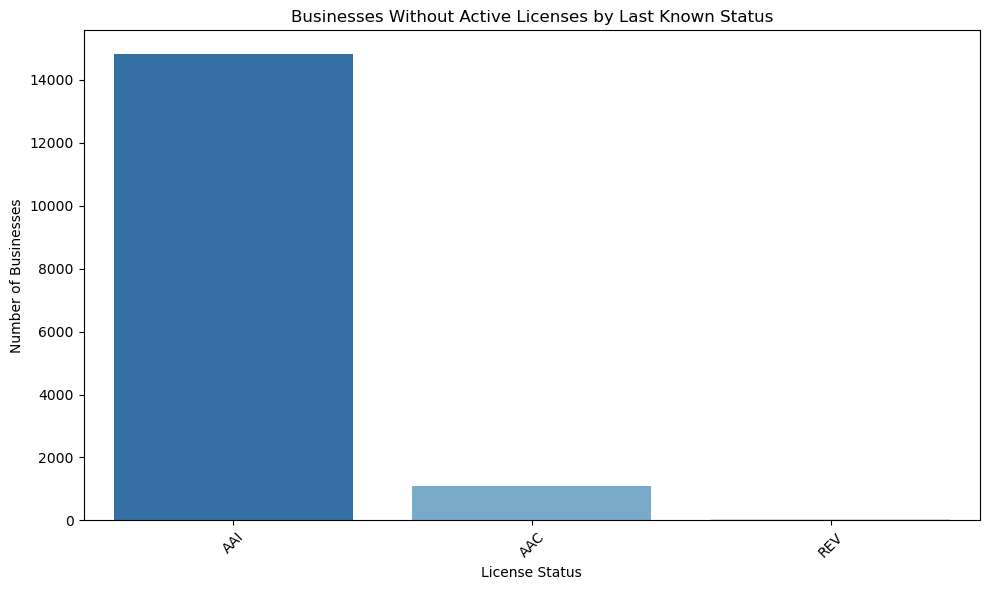

In [68]:
# businesses without active license
query2 = """
WITH latest_license AS (
    SELECT 
        l.business_id,
        l.license_status,
        l.end_date,
        ROW_NUMBER() OVER (PARTITION BY l.business_id ORDER BY l.end_date DESC) AS rn
    FROM licenses l
),
active_businesses AS (
    SELECT DISTINCT business_id
    FROM licenses
    WHERE license_status = 'AAI' AND end_date > CURDATE()
)
SELECT 
    latest.license_status,
    COUNT(*) AS business_count
FROM businesses b
LEFT JOIN active_businesses ab ON b.business_id = ab.business_id
JOIN latest_license latest 
  ON b.business_id = latest.business_id
WHERE ab.business_id IS NULL
  AND latest.rn = 1
GROUP BY latest.license_status
ORDER BY business_count DESC;
"""
df2 = pd.read_sql(query2, engine)

plt.figure(figsize=(10, 6))
sns.barplot(data=df2, x='license_status', y='business_count', palette='Blues_r')
plt.title("Businesses Without Active Licenses by Last Known Status")
plt.xlabel("License Status")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("lastknownstatus_fornon-active_bizneses.png", dpi=300)  # Save before showing
plt.show()


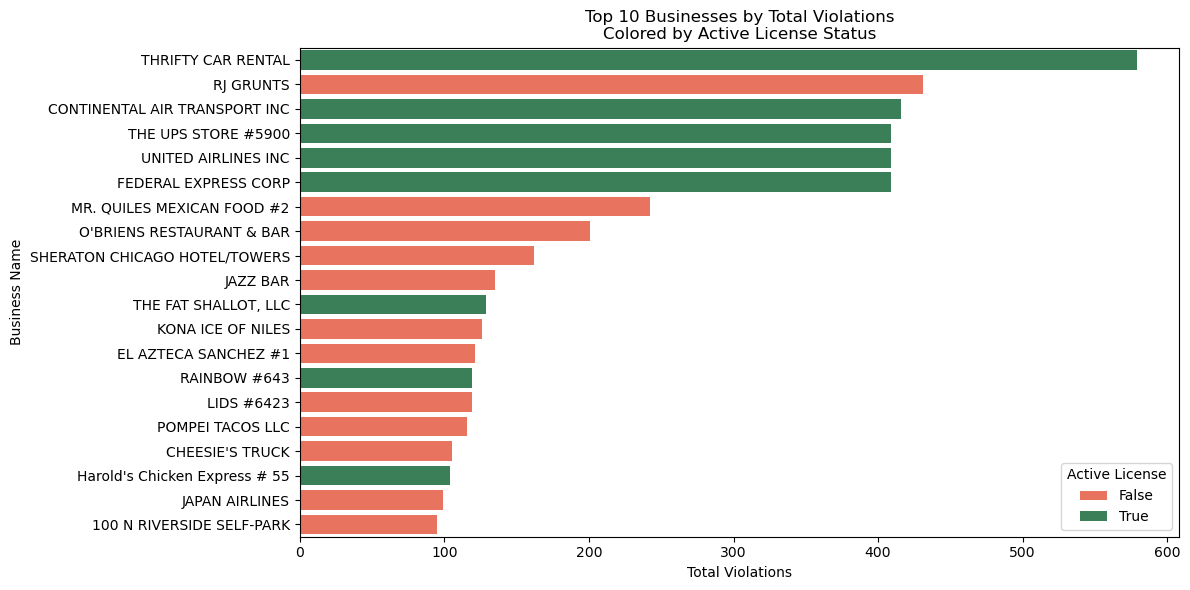

In [72]:
# Query to get top 10 businesses by total violations and their latest license info
query = """
SELECT 
    b.business_id,
    b.dba_name,
    COUNT(v.violation_id) AS total_violations,
    MAX(l.end_date) AS latest_license_end,
    MAX(l.license_status) AS latest_license_status
FROM violations v
JOIN inspections i ON v.inspection_uid = i.inspection_uid
JOIN licenses l ON i.location_id = l.location_id
                AND i.inspection_date BETWEEN l.start_date AND l.end_date
JOIN businesses b ON l.business_id = b.business_id
GROUP BY b.business_id, b.dba_name
ORDER BY total_violations DESC
LIMIT 20;

"""

df = pd.read_sql(query, engine)

# Determine if license is still active
df['license_active'] = (df['latest_license_status'] == 'AAI') & (
    pd.to_datetime(df['latest_license_end']) > pd.Timestamp.now())

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='total_violations',
    y='dba_name',
    hue='license_active',
    palette={True: 'seagreen', False: 'tomato'}
)
plt.title("Top 10 Businesses by Total Violations\nColored by Active License Status")
plt.xlabel("Total Violations")
plt.ylabel("Business Name")
plt.legend(title='Active License')
plt.tight_layout()
plt.savefig("top_violators.png", dpi=300)  # Save before showing
plt.show()


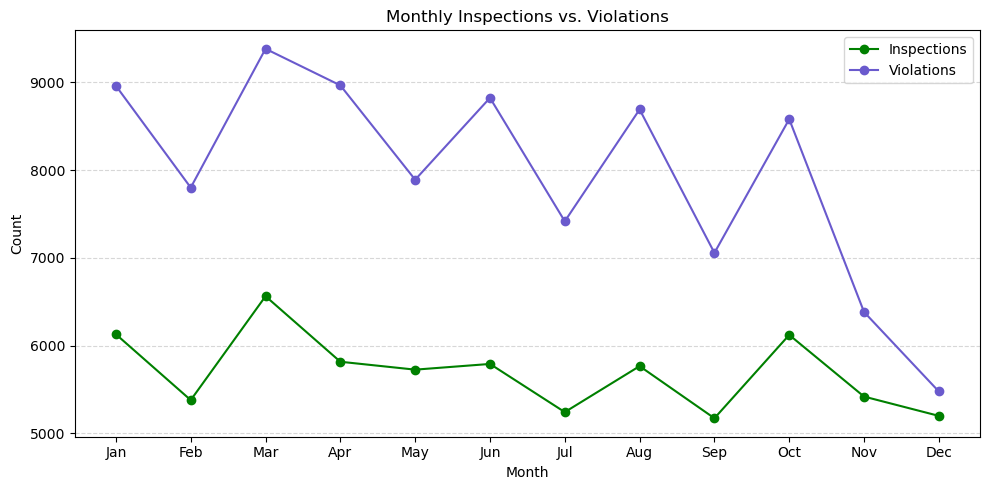

In [64]:
query4 = """
SELECT 
    MONTH(i.inspection_date) AS month,
    COUNT(DISTINCT i.inspection_uid) AS total_inspections,
    COUNT(v.violation_id) AS total_violations,
    ROUND(COUNT(v.violation_id) / COUNT(DISTINCT i.inspection_uid), 2) AS violation_rate
FROM inspections i
LEFT JOIN violations v ON i.inspection_uid = v.inspection_uid
GROUP BY month
ORDER BY month;
"""

df_vbm = pd.read_sql(query4, engine)

# Convert numeric months to names
df_vbm['month'] = df_vbm['month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(10, 5))
plt.plot(df_vbm['month'], df_vbm['total_inspections'], marker='o', label='Inspections', color='green')
plt.plot(df_vbm['month'], df_vbm['total_violations'], marker='o', label='Violations', color='slateblue')
plt.title('Monthly Inspections vs. Violations')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("inspectionsVSviolations.png", dpi=300)  # Save before showing
plt.show()

In [62]:
# # expiring licenses in the next 6 months

# query5 = """
# SELECT 
#     DATE_FORMAT(end_date, '%%Y-%%m') AS expiration_month,
#     COUNT(*) AS expiring_count
# FROM licenses
# WHERE end_date BETWEEN CURDATE() AND DATE_ADD(CURDATE(), INTERVAL 8 MONTH)
# GROUP BY expiration_month
# ORDER BY expiration_month;
# """

# df_exp6 = pd.read_sql(query5, engine)

# plt.figure(figsize=(8, 5))
# sns.barplot(data=df_exp6, x='expiration_month', y='expiring_count', color='steelblue')
# plt.title('License Expirations by Month (Next 8 Months)')
# plt.xlabel('Month')
# plt.ylabel('Number of Expiring Licenses')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

“Which ZIP codes have the most active businesses?”
(This helps identify business hubs and inform resource allocation or development efforts.)

https://github.com/smartchicago/chicago-atlas/blob/master/db/import/zipcodes.geojson - geojson for chicago zip codes

Skipping field adjacent_zips: unsupported OGR type: 5
Skipping field adjacent_community_areas: unsupported OGR type: 5


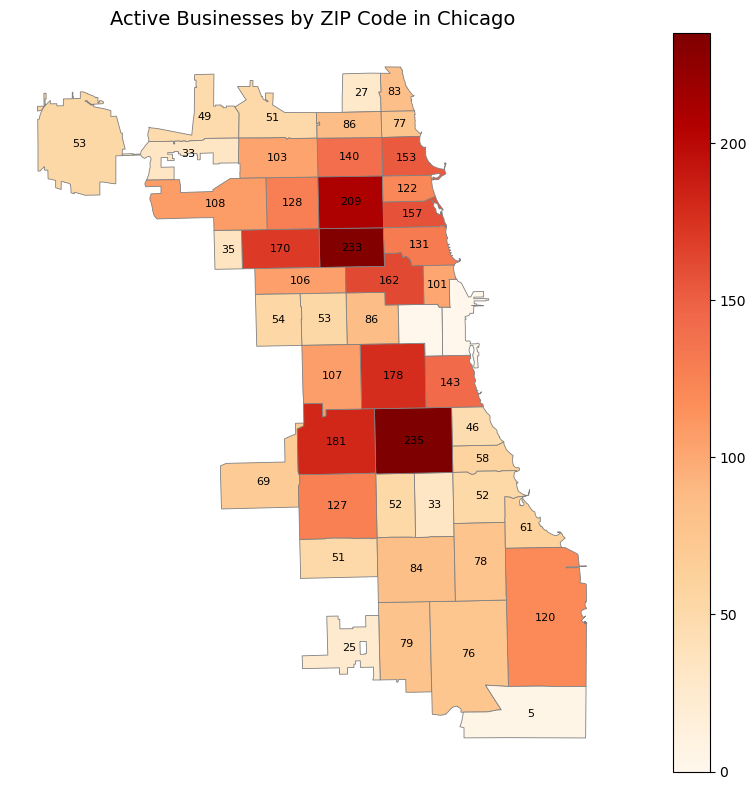

In [60]:
query8 = """
SELECT 
    loc.zip_code,
    COUNT(DISTINCT l.business_id) AS active_businesses
FROM licenses l
JOIN locations loc ON l.location_id = loc.location_id
WHERE l.license_status = 'AAI'
  AND l.end_date > CURDATE()
  AND loc.zip_code IS NOT NULL
GROUP BY loc.zip_code
ORDER BY active_businesses DESC;
"""
df_businesses = pd.read_sql(query8, engine)
gdf_zip = gpd.read_file('zipcodes.geojson')

# Ensure ZIP code columns are of the same type
gdf_zip['zip_code'] = gdf_zip['ZIP'].astype(str)
df_businesses['zip_code'] = df_businesses['zip_code'].astype(str)

# Merge the GeoDataFrame with the business data
gdf_merged = gdf_zip.merge(df_businesses, on='zip_code', how='left')

# Fill NaN values with 0 for ZIP codes with no active businesses
gdf_merged['active_businesses'] = gdf_merged['active_businesses'].fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
gdf_merged.plot(
    column='active_businesses',
    cmap='OrRd',
    linewidth=0.6,
    ax=ax,
    edgecolor='gray',  # ← this is okay here because it's a GeoDataFrame.plot
    legend=True,
)

# Add labels at the centroid of each polygon
for idx, row in gdf_merged.iterrows():
    if row['active_businesses'] > 0:
        centroid = row['geometry'].centroid
        ax.text(
            centroid.x,
            centroid.y,
            int(row['active_businesses']),
            ha='center',
            va='center',
            fontsize=8,
            color='black'
        )

# 6. Style
ax.set_title('Active Businesses by ZIP Code in Chicago', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig("activebiz_heatmap.png", dpi=300)  # Save before showing
plt.show()

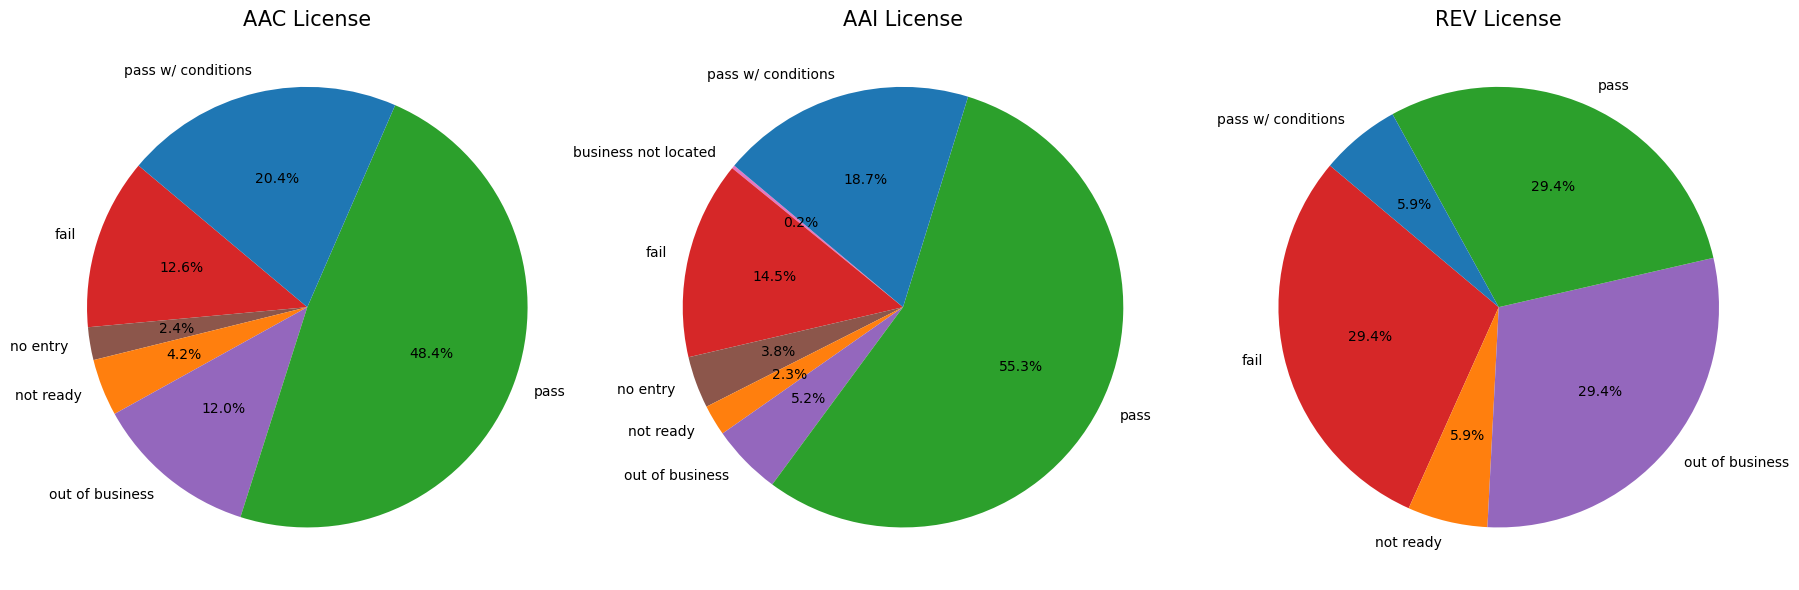

In [58]:
# Load data
query = """
SELECT 
    l.license_status,
    LOWER(i.result) AS inspection_result,
    COUNT(*) AS total
FROM inspections i
JOIN licenses l 
    ON i.location_id = l.location_id
   AND i.inspection_date BETWEEN l.start_date AND l.end_date
GROUP BY l.license_status, LOWER(i.result)
ORDER BY l.license_status, inspection_result;
"""
df = pd.read_sql(query, engine)

# fixed color map for inspection result color consistency
color_map = {
    'pass': '#2ca02c',
    'fail': '#d62728',
    'out of business': '#9467bd',
    'not ready': '#ff7f0e',
    'no entry': '#8c564b',
    'business not located': '#e377c2',
    'out of business - change of ownership': '#bcbd22',
    'pass w/ conditions': '#1f77b4',
    'not inspected': '#7f7f7f'
}

unique_statuses = df['license_status'].unique()
n = len(unique_statuses)
fig, axs = plt.subplots(1, n, figsize=(6 * n, 6))

for i, status in enumerate(unique_statuses):
    subset = df[df['license_status'] == status]
    labels = subset['inspection_result']
    values = subset['total']
    colors = [color_map.get(label, '#cccccc') for label in labels]  # default gray for unknowns

    axs[i].pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        textprops={'fontsize': 10}
    )
    axs[i].set_title(f'{status} License', fontsize=15)
    axs[i].axis('equal')

plt.tight_layout()
plt.savefig("inspection_results_by_license_status.png", dpi=300)  # Save before showing
plt.show()

In [308]:
# plt.savefig("inspection_results_by_license_status.png", dpi=300)  # Save before showing


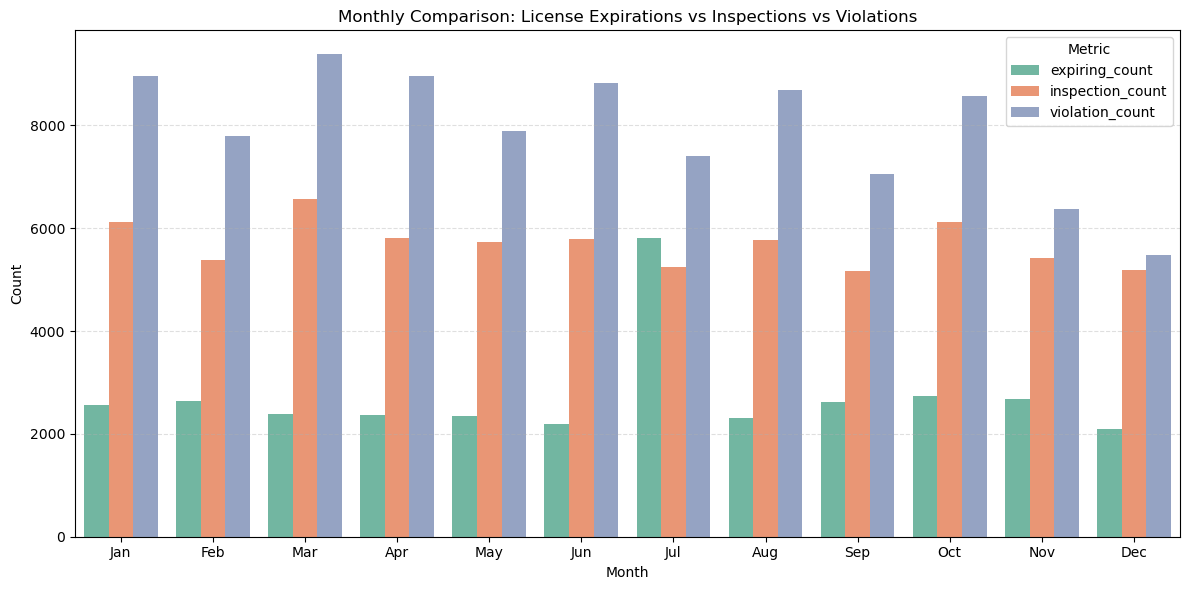

In [52]:
#  licenses
query_licenses = """
SELECT 
    MONTH(end_date) AS month_number,
    COUNT(*) AS expiring_count
FROM licenses
WHERE end_date IS NOT NULL
GROUP BY month_number
ORDER BY month_number;
"""
df_licenses = pd.read_sql(query_licenses, engine)

#  inspections
query_inspections = """
SELECT 
    MONTH(inspection_date) AS month_number,
    COUNT(*) AS inspection_count
FROM inspections
WHERE inspection_date IS NOT NULL
GROUP BY month_number
ORDER BY month_number;
"""
df_inspections = pd.read_sql(query_inspections, engine)

# violations
query_violations = """
SELECT 
    MONTH(i.inspection_date) AS month_number,
    COUNT(v.violation_id) AS violation_count
FROM inspections i
JOIN violations v ON i.inspection_uid = v.inspection_uid
WHERE i.inspection_date IS NOT NULL
GROUP BY month_number
ORDER BY month_number;
"""
df_violations = pd.read_sql(query_violations, engine)

df_all = df_licenses.merge(df_inspections, on='month_number').merge(df_violations, on='month_number')
df_all['month_abbr'] = df_all['month_number'].apply(lambda x: calendar.month_abbr[x])

df_all_melted = df_all.melt(
    id_vars='month_abbr',
    value_vars=['expiring_count', 'inspection_count', 'violation_count'],
    var_name='Metric',
    value_name='Count'
)

# Step 5: Plot side-by-side bars
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all_melted, x='month_abbr', y='Count', hue='Metric', palette='Set2')
plt.title('Monthly Comparison: License Expirations vs Inspections vs Violations')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("monthlycomparison.png", dpi=300)  # Save before showing
plt.show()

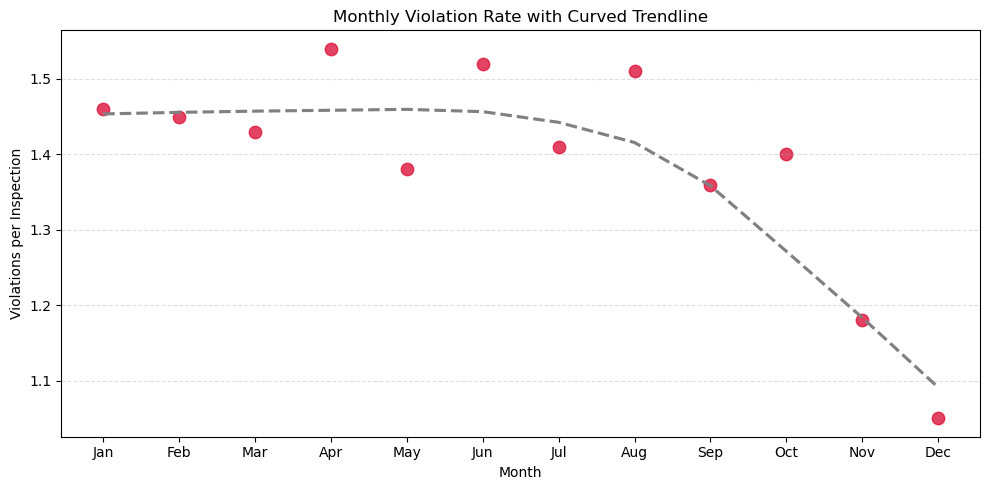

In [54]:
query5 = """
SELECT 
    MONTH(i.inspection_date) AS month,
    ROUND(COUNT(v.violation_id) / COUNT(DISTINCT i.inspection_uid), 2) AS violation_rate
FROM inspections i
LEFT JOIN violations v ON i.inspection_uid = v.inspection_uid
GROUP BY month
ORDER BY month;
"""
df_vpi = pd.read_sql(query5, engine)

# Step 3: Plot line chart of violation rate
plt.figure(figsize=(10, 5))
sns.regplot(
    x='month',
    y='violation_rate',
    data=df_vpi,
    lowess=True,
    scatter=True,
    ci=None,
    color='crimson',
    line_kws={'linestyle': '--', 'color': 'gray'},
    scatter_kws={'s': 80}
)
# Clean labels
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[m] for m in range(1, 13)])
plt.title('Monthly Violation Rate with Curved Trendline')
plt.xlabel('Month')
plt.ylabel('Violations per Inspection')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("monthlyviolationrate.png", dpi=300)  # Save before showing
plt.show()